# Network Flow Data, Threat Detection Using RNN and DBSCAN

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

## Importing Data

In [22]:
pd.set_option('display.max_columns', None)

In [23]:
df = pd.read_csv ('/Users/asadejaz/PycharmProjects/ASU_ONR/network_data.csv')

In [24]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,624,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:32 AM,3974862,29,44,86.0,59811.0,86.0,0.0,2.965517,15.969799,1460.0,0.0,1359.340909,372.027190,15068.950821,18.365417,55206.416667,195478.316654,1566821.0,167.0,3735347.0,133405.25,341775.688712,1805015.0,167.0,3974862.0,92438.651163,248174.820574,1566821.0,3997.0,0,0,0,0,768,896,7.295851,11.069567,0.0,1460.0,809.418919,728.862428,531240.438541,0,1,0,0,0,0,0,0,1.0,820.506849,2.965517,1359.340909,0,0,0,0,0,0,29,86,44,59811,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,1,625,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:36 AM,63,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,31746.031746,63.000000,0.000000,63.0,63.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,20,20,15873.015873,15873.015873,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,1.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,-1,17520,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,2,626,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:36 AM,476078,2,6,86.0,3037.0,86.0,0.0,43.000000,60.811183,1460.0,0.0,506.166667,740.224403,6559.849436,16.803969,68011.142857,110862.707451,232203.0,6.0,134.0,134.00,0.000000,134.0,134.0,476078.0,95215.600000,123467.303580,232601.0,6.0,0,0,0,0,40,136,4.200992,12.602977,0.0,1460.0,347.000000,632.515217,400075.500000,0,1,0,0,0,0,0,0,3.0,390.375000,43.000000,506.166667,0,0,0,0,0,0,2,86,6,3037,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,3,627,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:37 AM,151,2,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,19867.549669,75.500000,98.287843,145.0,6.0,145.0,145.00,0.000000,145.0,145.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,0,40,20,13245.033113,6622.516556,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,1,0,-1,17520,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,4,628,192.168.4.118-203.73.24.75-4506-80-6,192.168.4.118,4506,203.73.24.75,80,6,12/06/2010 08:34:37 AM,472507,2,5,73.0,1050.0,73.0,0.0,36.500000,51.618795,1050.0,0.0,210.000000,469.574275,2376.684367,14.814595,78751.166667,118675.492251,232355.0,7.0,179.0,179.00,0.000000,179.0,179.0,472507.0,118126.750000,131726.857333,232875.0,7.0,0,0,0,0,40,116,4.232742,10.581854,0.0,1050.0,140.375000,368.430624,135741.125000,0,1,0,0,0,0,0,0,2.0,160.428571,36.500000,210.000000,0,0,0,0,0,0,2,73,5,1050,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


## Cleaning and Initial Preprocessing

### Checking for null or infinite Values

In [25]:
df.isnull().sum()

Unnamed: 0.1    0
Unnamed: 0      0
Flow ID         0
Src IP          0
Src Port        0
               ..
Idle Mean       0
Idle Std        0
Idle Max        0
Idle Min        0
Label           0
Length: 86, dtype: int64

In [26]:
df.isin([np.inf, -np.inf]).sum()

Unnamed: 0.1    0
Unnamed: 0      0
Flow ID         0
Src IP          0
Src Port        0
               ..
Idle Mean       0
Idle Std        0
Idle Max        0
Idle Min        0
Label           0
Length: 86, dtype: int64

# Initial Data Cleaning

In [27]:
df1 = df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'Flow ID', 'Src IP', 'Dst IP', 
        'Timestamp', 'Label'], axis = 1)

### Why drop them
Flow ID
Why drop: It’s just a unique identifier. It doesn’t carry any useful statistical or behavioral information for clustering.

Purpose: Primarily used for indexing or matching, not pattern detection.

Src IP (Source IP)
Why drop: In DDoS attacks, IPs are often spoofed or randomized.

Including it would bias clustering toward patterns in IPs that may not reflect actual behavior.

Alternative use: Later, you can do a frequency analysis of IPs within clusters.

Dst IP (Destination IP)
Why drop: If you're analyzing one DDoS victim (e.g., all traffic to a single target), Dst IP will have low variability and won’t help clustering.

If multiple targets: You might retain this column for segmenting by target.

Timestamp
Why drop: Raw timestamps aren’t useful for clustering unless converted to something meaningful (e.g., time deltas or request rate).

Alternative: Engineer a feature like packets per second, burst duration, or time between flows before dropping it.

Label
Why drop: For unsupervised clustering, we don’t want the model to “see” the true label.

Once clustering is done, you can reattach Label to compare unsupervised clusters vs. known labels for validation or anomaly detection.

### Adjust Infinite Values

Because Standard Scaler can not deal with infinitely Large or Small Values

In [32]:
df1.replace([np.inf, -np.inf] , np.nan, inplace = True)
df1.dropna(inplace = True)

### Standard Scaling Data

we will use PCA to reduce Noise and Standard scale to standardize features like packet_size that can cause imbalance

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df1)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

# Clustering Data Using DBSCAN 

In [36]:
from sklearn.cluster import DBSCAN

we will use eps as 0.5 and min samples as 10 to minimize separation and group tightly based on similarities in flow, it will help us find outliers

In [39]:
db = DBSCAN (eps = 0.5, min_samples = 10)
clusters = db.fit_predict(X_pca)
df.loc[df1.index, 'Cluster'] = clusters

## Visualizing Clusters

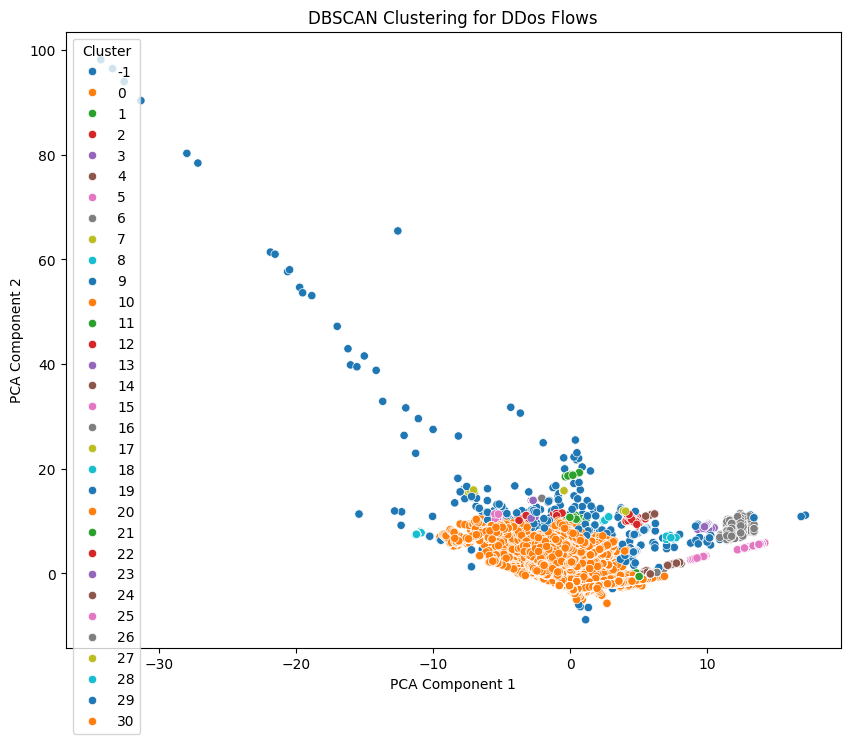

In [41]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = X_pca[:, 0], y = X_pca[:, 1], hue = clusters, palette = 'tab10')
plt.title('DBSCAN Clustering for DDos Flows')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title = 'Cluster')
plt.show()

The plot above shows dimensionality reduction for 2D representation. Each color represents a separate cluster (Cluster 0–14), while points labeled as -1 (blue dots) are considered noise or outliers by DBSCAN.

The large central cluster (Cluster 0) represents the dominant traffic pattern that is DDoS. Smaller clusters suggest distinct flow behavior patterns, and the presence of outliers indicates potentially anomalous flows, such as novel attack types or rare benign behaviors.

This analysis supports post-anomaly detection grouping and provides insight into the structure and diversity of anomalous traffic in the dataset.

In [43]:
cluster_summary = df.groupby('Cluster').mean(numeric_only = True)
cluster_summary.T

Cluster,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
Unnamed: 0.1,3.238068e+04,4.820357e+04,2.388133e+04,1.854162e+04,2.473979e+04,8.563926e+04,2.477340e+04,6.349550e+04,2.266931e+04,41672.741935,23820.583333,4.563640e+04,9.678817e+04,2.117539e+04,1.888600e+04,4.610831e+04,4.645493e+04,2.581800e+04,2.589141e+04,2.600917e+04,9.796346e+04,45509.500000,4.679329e+04,6.290779e+04,9.082074e+04,4.633350e+04,9.695188e+04,7.785580e+04,8.131162e+04,95126.2,9.525825e+04,97138.666667
Unnamed: 0,1.088586e+05,8.102737e+04,1.159386e+05,8.694819e+04,1.096091e+05,5.318089e+04,1.102386e+05,5.701293e+04,1.022262e+05,216481.451613,106505.000000,5.458300e+04,4.629820e+04,9.520611e+04,8.554500e+04,2.442573e+05,2.464737e+05,1.137072e+05,1.138167e+05,1.139744e+05,5.130380e+04,240484.916667,2.495840e+05,1.383480e+05,6.184153e+04,2.457012e+05,4.371631e+04,2.429980e+04,2.775562e+04,41570.2,4.170225e+04,43582.666667
Src Port,2.985091e+04,3.323376e+04,4.846058e+04,3.171050e+04,4.969316e+04,3.222525e+04,4.082925e+04,2.297757e+04,3.493362e+04,50335.967742,37086.250000,3.496347e+04,3.694155e+04,3.146228e+04,2.334820e+04,5.728725e+04,5.709545e+04,5.252173e+04,5.237707e+04,5.121257e+04,4.534787e+04,54818.250000,5.128646e+04,5.005567e+04,3.955547e+04,5.347650e+04,3.790360e+04,4.729906e+04,4.667650e+04,38054.8,3.810106e+04,37931.955556
Dst Port,9.167203e+01,8.042715e+01,8.000000e+01,1.026875e+02,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,80.000000,80.000000,1.284000e+02,8.000000e+01,8.000000e+01,1.526000e+02,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,80.000000,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,8.000000e+01,80.0,8.000000e+01,80.000000
Protocol,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000,6.000000,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.0,6.000000e+00,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Active Min,3.702218e+06,3.277250e+05,6.487723e+06,3.468336e+06,2.550183e+06,0.000000e+00,2.639893e+05,0.000000e+00,7.950000e+01,0.000000,0.000000,4.192980e+06,0.000000e+00,6.875260e+05,5.335454e+05,0.000000e+00,0.000000e+00,1.996507e+06,2.040852e+06,1.784895e+02,4.373617e+06,0.000000,3.031079e+06,2.237884e+06,5.476572e+05,2.875000e+00,2.463062e+00,0.000000e+00,4.582062e+06,1042242.1,8.486986e+04,0.000000
Idle Mean,3.351540e+07,5.512103e+06,6.142907e+07,4.970905e+07,1.213312e+07,1.289805e+07,1.206176e+07,3.819573e+07,2.058023e+06,0.000000,0.000000,2.576060e+07,1.801194e+06,1.470061e+07,2.641734e+07,5.877531e+07,7.551207e+07,1.268653e+07,1.589544e+07,2.459772e+07,2.388261e+07,0.000000,2.231145e+07,6.202023e+07,1.028306e+08,1.166306e+08,1.040037e+08,9.973820e+07,2.388624e+07,77583041.3,5.132413e+07,0.000000
Idle Std,3.268406e+06,5.645598e+05,2.980263e+05,2.296262e+06,6.765258e+06,0.000000e+00,3.356610e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,5.750868e+06,0.000000e+00,1.883886e+06,2.633826e+06,0.000000e+00,0.000000e+00,6.426859e+06,9.798133e+06,2.156999e+07,2.057473e+07,0.000000,2.060014e+07,1.031253e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.063673e+07,0.0,0.000000e+00,0.000000
Idle Max,3.681200e+07,6.092191e+06,6.179557e+07,5.317393e+07,2.177689e+07,1.289805e+07,1.443524e+07,3.819573e+07,2.058023e+06,0.000000,0.000000,3.350040e+07,1.801194e+06,1.681003e+07,3.004821e+07,5.877531e+07,7.551207e+07,2.197994e+07,3.207866e+07,5.658007e+07,5.327054e+07,0.000000,5.237816e+07,7.670255e+07,1.028306e+08,1.166306e+08,1.040037e+08,9.973820e+07,5.324712e+07,77583041.3,5.132413e+07,0.000000


# Create a RNN, LTSM Model

### RNN, LTSM model is being used because we do not want to classify we just want to learn behavior, we'll use sequential for that.

In [47]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [48]:
SEQ_LEN = 10
X = create_sequences(df1, SEQ_LEN)

In [54]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

In [51]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)

In [60]:
model = Sequential([
    LSTM(64, activation = 'relu', input_shape = (SEQ_LEN, X.shape[2]), return_sequences = False), RepeatVector(SEQ_LEN),
    LSTM(64, activation = 'relu', return_sequences = True), TimeDistributed(Dense(X.shape[2]))
])

In [61]:
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 79)         │         5,135 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,023 (293.06 KB)

 Trainable params: 75,023 (293.06 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history  = model.fit(X_train, X_train , epochs = 30, batch_size = 32, validation_split = 0.1)
reconstructed = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed, 2), axis = (1, 2))

Epoch 1/30


2025-05-06 00:14:04.309510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 452s 199ms/step - loss: 53806213627904.0000 - val_loss: 27894757720064.0000
Epoch 2/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 483s 215ms/step - loss: 29639388954624.0000 - val_loss: 27471281913856.0000
Epoch 3/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 516s 229ms/step - loss: 27889070243840.0000 - val_loss: 30274536603648.0000
Epoch 4/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 489s 217ms/step - loss: 28121858310144.0000 - val_loss: 26741825339392.0000
Epoch 5/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 489s 217ms/step - loss: 26789472632832.0000 - val_loss: 27491263578112.0000
Epoch 6/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 488s 217ms/step - loss: 27211119722496.0000 - val_loss: 26858743660544.0000
Epoch 7/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 491s 218ms/step - loss: 26251058216960.0000 - val_loss: 27680317636608.0000
Epoch 8/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 492s 219ms/step - loss: 27097007390720.0000 - val_loss: 25512822964224.0000
Epoch 9/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 498s 221ms/step - loss: 2

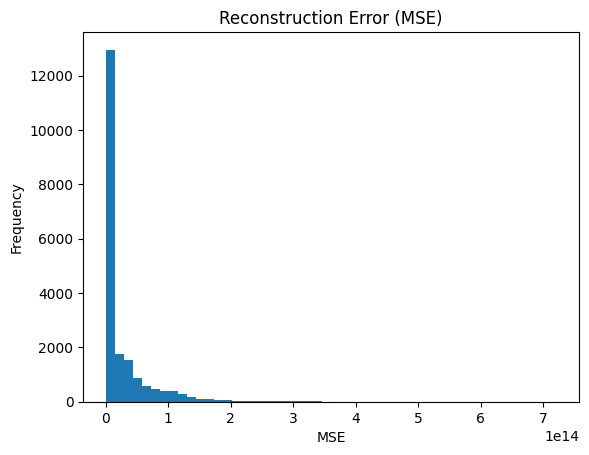

In [63]:
import matplotlib.pyplot as plt
plt.hist(mse, bins=50)
plt.title("Reconstruction Error (MSE)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()